In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

import torch
import torch.nn as nn

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, Dataset

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report

In [2]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
USE_model = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [3]:
torch.manual_seed(42)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU.")

No GPU available, using CPU.


In [4]:
def embed(input):
    return USE_model(input)

In [5]:
df = pd.read_csv('../data/train.csv')

In [6]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [7]:
print(f"Initial dataframe has {len(df)} rows.")
null_rows = df[df.isnull().values.any(1)]
print(f"Dataframe has {len(null_rows)} null rows.")
df = df.dropna(how='any')
print(f"Dataframe has {len(df)} rows after removing null values.")

Initial dataframe has 404290 rows.
Dataframe has 3 null rows.
Dataframe has 404287 rows after removing null values.


### Model Definition

In [8]:
class EmbeddingConcatenateModel(nn.Module):
    
    def __init__(self, input_dim, num_layers, hidden_size=256, use_batchnorm=False):
        super(EmbeddingConcatenateModel, self).__init__()
        
        layers = []
        
        # input layer
        layers.append(nn.Linear(input_dim, hidden_size))
        
        if use_batchnorm:
            layers.append(nn.BatchNorm1d(hidden_size))
        
        # hidden layers
        for _ in range(num_layers - 2):
            layers.extend([nn.ReLU(), nn.Linear(hidden_size, hidden_size)])
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(hidden_size))
        
        # output layer
        layers.append(nn.Linear(hidden_size, 1))
        
        self.fc = nn.Sequential(*layers)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

### Dataset Preparation

In [9]:
X = df[['question1', 'question2']]
X['q1_embeddings'] = X['question1'].apply(lambda x: embed([x]))
X['q2_embeddings'] = X['question2'].apply(lambda x: embed([x]))

y = df.iloc[:, -1]

C:\Users\eugen\AppData\Local\Temp\ipykernel_5316\1712897865.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['q1_embeddings'] = X['question1'].apply(lambda x: embed([x]))
C:\Users\eugen\AppData\Local\Temp\ipykernel_5316\1712897865.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['q2_embeddings'] = X['question2'].apply(lambda x: embed([x]))


In [10]:
X['q1_embeddings'] = X['q1_embeddings'].apply(lambda x: np.array(x).reshape(-1))
X['q2_embeddings'] = X['q2_embeddings'].apply(lambda x: np.array(x).reshape(-1))

C:\Users\eugen\AppData\Local\Temp\ipykernel_5316\1994835437.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['q1_embeddings'] = X['q1_embeddings'].apply(lambda x: np.array(x).reshape(-1))
C:\Users\eugen\AppData\Local\Temp\ipykernel_5316\1994835437.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['q2_embeddings'] = X['q2_embeddings'].apply(lambda x: np.array(x).reshape(-1))


In [11]:
X = X[['q1_embeddings', 'q2_embeddings']]
X.head()

,q1_embeddings,q2_embeddings
0,"[0.0021821777, -0.071323544, -0.008949716, -0....","[0.018747583, -0.08102848, -0.0034117287, -0.0..."
1,"[-0.008116845, -0.04054194, 0.050406188, -0.00...","[-0.02633016, -0.056345083, 0.05864444, -0.076..."
2,"[-0.02507621, -0.032699287, 0.030226452, -0.05...","[-0.019373588, -0.052194037, -0.049746674, 0.0..."
3,"[0.022798156, -0.06058688, -0.016114684, 0.049...","[-0.06627553, -0.09527444, 0.026091686, 0.0603..."
4,"[0.023056682, 0.047172908, -0.017179074, 0.034...","[-0.046064388, -0.009994284, 0.038086914, -0.0..."


In [12]:
# split into train/val, test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# split into train and val sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

In [47]:
# to be used for new unseen data
def get_question_embeddings(df):
    df['q1_embeddings'] = df['question1'].apply(lambda x: embed([x]))
    df['q2_embeddings'] = df['question2'].apply(lambda x: embed([x]))
    
    return df    

In [13]:
class DuplicateQuestionDataset(Dataset):

    def __init__(self, question_embeddings, labels):
        self.question_embeddings = question_embeddings
        self.labels = labels

    def __len__(self):
        return len(self.question_embeddings)

    def __getitem__(self, idx):
        q1_embeddings, q2_embeddings = self.question_embeddings.iloc[idx]
        
        # convert to numpy array
        q1_embeddings = np.array(q1_embeddings)
        q2_embeddings = np.array(q1_embeddings)

        # concatenate vectors to get a 1024-dimensional vector
        result = torch.cat((torch.from_numpy(q1_embeddings), torch.from_numpy(q2_embeddings)), 0).to(device)

        label = torch.tensor(self.labels.iloc[idx]).to(device)
        return result, label

In [14]:
# batch size
batch_size = 128

train_dataset = DuplicateQuestionDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DuplicateQuestionDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = DuplicateQuestionDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Model Initialisation & Hyperparameter Setting

In [49]:
# hyperparameters
num_layers = 3
hidden_size = 256
learning_rate = 0.0015

# constant
input_dim = 1024

# initialise model
model = EmbeddingConcatenateModel(input_dim, num_layers=num_layers, hidden_size=hidden_size, use_batchnorm=False).to(device)

# training mode
model.train()

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_params = sum(p.numel() for p in model.parameters())
total_params

328449

### Model Training

In [50]:
num_epochs = 10
lossi = []

# training loop
for epoch in range(num_epochs):
    total_loss = 0
    for embedding_diffs, labels in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(embedding_diffs)
        loss = criterion(outputs.reshape(-1), labels.float())
        
        # metrics
        lossi.append(loss.item())
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}: Loss = {total_loss/len(train_loader):.4f}")

  0%|          | 0/2022 [00:00<?, ?it/s]

Epoch 1: Loss = 0.5385


  0%|          | 0/2022 [00:00<?, ?it/s]

Epoch 2: Loss = 0.5016


  0%|          | 0/2022 [00:00<?, ?it/s]

Epoch 3: Loss = 0.4792


  0%|          | 0/2022 [00:00<?, ?it/s]

Epoch 4: Loss = 0.4577


  0%|          | 0/2022 [00:00<?, ?it/s]

Epoch 5: Loss = 0.4371


  0%|          | 0/2022 [00:00<?, ?it/s]

Epoch 6: Loss = 0.4178


  0%|          | 0/2022 [00:00<?, ?it/s]

Epoch 7: Loss = 0.3994


  0%|          | 0/2022 [00:00<?, ?it/s]

Epoch 8: Loss = 0.3838


  0%|          | 0/2022 [00:00<?, ?it/s]

Epoch 9: Loss = 0.3689


  0%|          | 0/2022 [00:00<?, ?it/s]

Epoch 10: Loss = 0.3560


Text(0.5, 1.0, 'Training Loss')

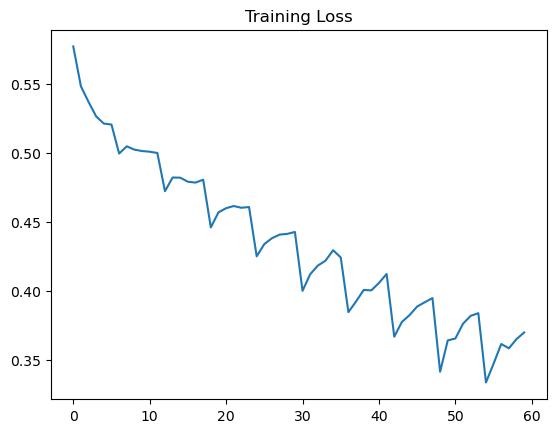

In [51]:
average_lossi = torch.tensor(lossi).view(-1, 337).mean(1)
plt.plot(average_lossi)
plt.title('Training Loss')

### Save Model

In [60]:
model_path = 'embd_concat_model.pth'

In [61]:
torch.save(model.state_dict(), model_path)

### Load Model (Skip here after training is done)

In [ ]:
model = EmbeddingConcatenateModel()
model.load_state_dict(torch.load(model_path))
model.eval()

### Model Evaluation

#### Training Accuracy

In [52]:
model.eval()
threshold = 0.5

with torch.no_grad():
    true_labels_train = []
    predicted_scores_train = []
    for concat_embeddings, labels in tqdm(train_loader):
        outputs = model(concat_embeddings)
        predicted = (outputs > threshold).float().view(-1)

        true_labels_train.extend(labels.cpu().numpy())
        predicted_scores_train.extend(outputs.cpu().numpy())

true_labels_train = np.array(true_labels_train)
predicted_scores_train = np.array(predicted_scores_train)

accuracy = accuracy_score(true_labels_train, (predicted_scores_train > threshold)) * 100
print(f"Train Accuracy: {accuracy:.2f}%")

  0%|          | 0/2022 [00:00<?, ?it/s]

Train Accuracy: 86.20%


#### Validation Accuracy

In [53]:
model.eval()
threshold = 0.5

with torch.no_grad():
    true_labels_val = []
    predicted_scores_val = []
    for concat_embeddings, labels in tqdm(val_loader):
        outputs = model(concat_embeddings)
        predicted = (outputs > threshold).float().view(-1)
        
        true_labels_val.extend(labels.cpu().numpy())
        predicted_scores_val.extend(outputs.cpu().numpy())

true_labels_val = np.array(true_labels_val)
predicted_scores_val = np.array(predicted_scores_val)

accuracy = accuracy_score(true_labels_val, (predicted_scores_val > threshold)) * 100
print(f"Validation Accuracy: {accuracy:.2f}%")

  0%|          | 0/506 [00:00<?, ?it/s]

Validation Accuracy: 75.69%


#### Test Accuracy

In [54]:
model.eval()
threshold = 0.5

with torch.no_grad():
    true_labels_test = []
    predicted_scores_test = []
    for concat_embeddings, labels in tqdm(test_loader):
        outputs = model(concat_embeddings)
        predicted = (outputs > threshold).float().view(-1)
        
        true_labels_test.extend(labels.cpu().numpy())
        predicted_scores_test.extend(outputs.cpu().numpy())

true_labels_test = np.array(true_labels_test)
predicted_scores_test = np.array(predicted_scores_test)

accuracy = accuracy_score(true_labels_test, (predicted_scores_test > threshold)) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

  0%|          | 0/632 [00:00<?, ?it/s]

Test Accuracy: 75.44%


### Other Classification Metrics

In [55]:
def print_classification_metrics(dataset='test'):
    labels = {
        'train': (true_labels_train, predicted_scores_train),
        'val': (true_labels_val, predicted_scores_val),
        'test': (true_labels_test, predicted_scores_test)
    }
    true, predicted = labels[dataset]

    print(classification_report(true, (predicted > threshold)))

    fpr, tpr, _ = roc_curve(true, predicted)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05]) 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{dataset.capitalize()} Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    print(f"AUC-ROC: {roc_auc:.2f}")

              precision    recall  f1-score   support

           0       0.88      0.90      0.89    163265
           1       0.83      0.79      0.81     95478

    accuracy                           0.86    258743
   macro avg       0.85      0.85      0.85    258743
weighted avg       0.86      0.86      0.86    258743



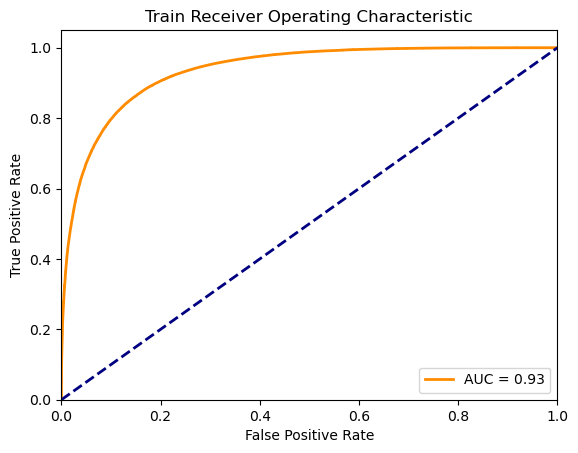

AUC-ROC: 0.93


In [56]:
print_classification_metrics(dataset='train')

              precision    recall  f1-score   support

           0       0.80      0.82      0.81     40733
           1       0.68      0.65      0.66     23953

    accuracy                           0.76     64686
   macro avg       0.74      0.73      0.74     64686
weighted avg       0.75      0.76      0.76     64686



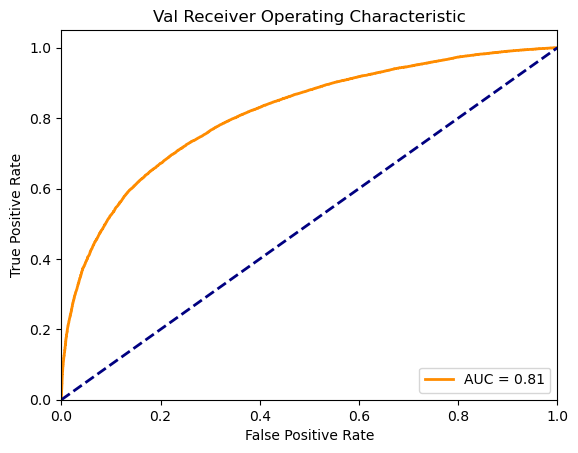

AUC-ROC: 0.81


In [57]:
print_classification_metrics(dataset='val')

              precision    recall  f1-score   support

           0       0.80      0.82      0.81     51026
           1       0.67      0.65      0.66     29832

    accuracy                           0.75     80858
   macro avg       0.74      0.73      0.73     80858
weighted avg       0.75      0.75      0.75     80858



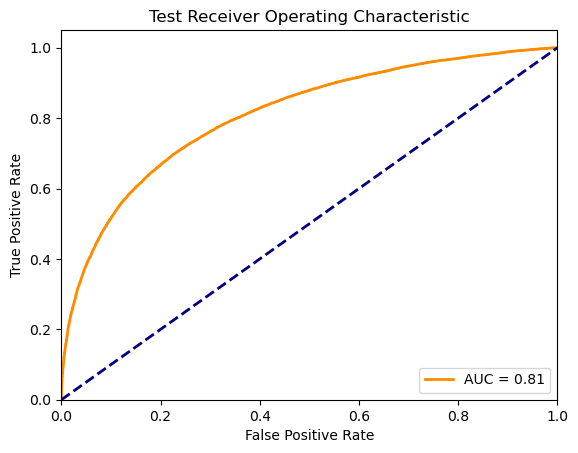

AUC-ROC: 0.81


In [58]:
print_classification_metrics(dataset='test')